# Modelando con Nones/Without Outliers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [2]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

In [3]:
miguel = pd.read_csv("../data_clean/miguel_pm10_clean_v2.csv",index_col=[1])
#cuauh = pd.read_csv("cuauh_pm10_clean.csv",index_col=[1])
#benito = pd.read_csv("benito_pm10_clean.csv",index_col=[1])

miguel.drop("Unnamed: 0",axis=1,inplace=True)
#cuauh.drop("Unnamed: 0",axis=1,inplace=True)
#benito.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
miguel_modelo= miguel.drop(["FECHA","HORA"],axis=1)
#cuauh_modelo= cuauh.drop(["FECHA","HORA","AÑO","MES"],axis=1)
split_date='2019-01-01'

train1=miguel_modelo[miguel_modelo.index<=split_date].copy()
test1=miguel_modelo[miguel_modelo.index>split_date].copy()

#train2=cuauh_modelo[cuauh_modelo.index<=split_date].copy()
#test2=cuauh_modelo[cuauh_modelo.index>split_date].copy()

In [5]:
miguel_modelo=miguel_modelo.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})
train1=train1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})
test1=test1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})

#train2=train2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
#test2=test2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train1.ds=pd.to_datetime(train1.ds)
#train2.ds=pd.to_datetime(train2.ds)
test1.ds=pd.to_datetime(test1.ds)
#test2.ds=pd.to_datetime(test2.ds)

#train2.head()

## Modelando

In [6]:
modelo1=Prophet(n_changepoints=15,
               changepoint_prior_scale=0.6,
               #seasonality_prior_scale = 10
              ).fit(train1)
pred1=modelo1.predict(test1)

In [7]:
mape(test1.y, pred1.yhat), smape(test1.y, pred1.yhat)

(39.89896742230674, 33.49945587088934)

In [8]:
mean_squared_error(test1.y, pred1.yhat)**0.5,mean_absolute_error(test1.y, pred1.yhat)

(19.118172830825657, 13.681818923193974)

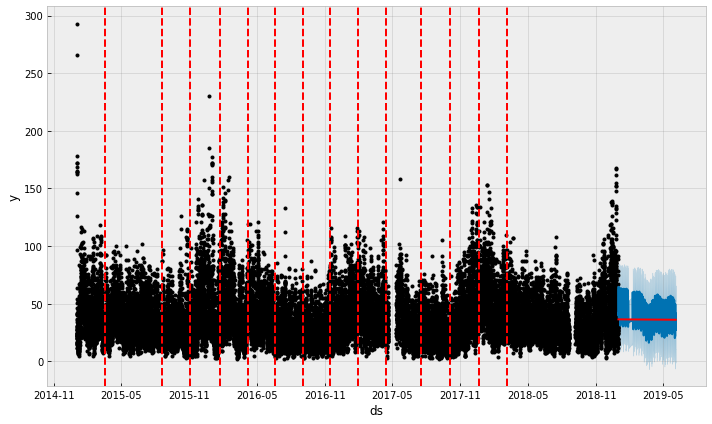

In [9]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo A
fig = modelo1.plot(pred1)
a = add_changepoints_to_plot(fig.gca(), modelo1, pred1)

## Modelando "make_future"

In [11]:
test1.shape

(3274, 2)

In [12]:
modelo2=Prophet(n_changepoints=17,
                    changepoint_prior_scale=0.65,
                    seasonality_prior_scale = 10
                    ).fit(train1)

In [13]:
future = modelo2.make_future_dataframe(freq='H',periods=3274)
forecast = modelo2.predict(future)

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36307,2019-05-17 05:00:00,39.145179,12.848453,61.573043,27.494038,50.401587,-2.345903,-2.345903,-2.345903,-7.970889,...,1.645430,1.645430,1.645430,3.979555,3.979555,3.979555,0.0,0.0,0.0,36.799275
36308,2019-05-17 06:00:00,39.145507,14.441612,64.645112,27.486447,50.406738,0.613973,0.613973,0.613973,-5.029685,...,1.654415,1.654415,1.654415,3.989243,3.989243,3.989243,0.0,0.0,0.0,39.759480
36309,2019-05-17 07:00:00,39.145836,18.883123,70.654071,27.478856,50.411889,4.837435,4.837435,4.837435,-0.825764,...,1.664340,1.664340,1.664340,3.998860,3.998860,3.998860,0.0,0.0,0.0,43.983271
36310,2019-05-17 08:00:00,39.146164,23.280745,75.230384,27.471264,50.417040,9.976979,9.976979,9.976979,4.293905,...,1.674670,1.674670,1.674670,4.008404,4.008404,4.008404,0.0,0.0,0.0,49.123143
36311,2019-05-17 09:00:00,39.146493,29.810231,79.866202,27.463673,50.422191,15.115090,15.115090,15.115090,9.412437,...,1.684777,1.684777,1.684777,4.017875,4.017875,4.017875,0.0,0.0,0.0,54.261582


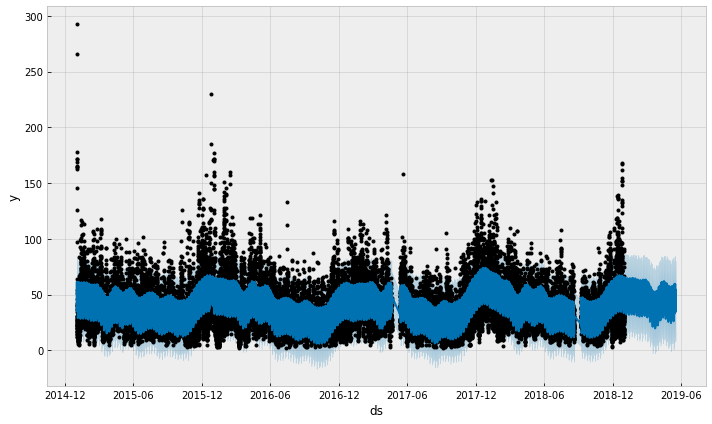

In [15]:
fig1 = modelo2.plot(forecast)

In [ ]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}